In [1]:
import os
import sys
import torch

import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from image_util import *

In [2]:
class MyDiffuseBSDF(psdr.BSDF):
    def __init__(self, albedo):
        psdr.BSDF.__init__(self)
        self.texture = psdr.Bitmap3fD(albedo)

    def anisotropic(self):
        return False

    def to_string(self):
        return "MyDiffuseBSDF[id=" + self.id + "]";

    def eval(self, its, wo, active):
        wo.z = drjit.mulsign(wo.z, its.wi.z);
        its.wi.z = drjit.abs(its.wi.z);
        cos_theta_i = psdr.Frame.cos_theta(its.wi)
        cos_theta_o = psdr.Frame.cos_theta(wo)
        active &= cos_theta_i > 0
        active &=  cos_theta_o > 0
        return self.texture.eval(its.uv) * psdr.InvPi * cos_theta_o & active

    def sample(self, its, sample, active):
        with drjit.suspend_grad():
            its.wi.z = drjit.abs(its.wi.z);
            cos_theta_i = psdr.Frame.cos_theta(its.wi);
            bs = psdr.BSDFSample()
            sample2 = Vector2fD(sample.x, sample.y)
            bs.wo = psdr.square_to_cosine_hemisphere(sample2);
            bs.eta = 1.0;
            bs.pdf = psdr.square_to_cosine_hemisphere_pdf(bs.wo);
            active &= cos_theta_i > 0.
            bs.is_valid = active
            return bs

    def pdf(self, its, wo, active):
        with drjit.suspend_grad():
            wo.z = drjit.mulsign(wo.z, its.wi.z);
            its.wi.z = drjit.abs(its.wi.z);
            cos_theta_i = psdr.Frame.cos_theta(its.wi);
            cos_theta_o = psdr.Frame.cos_theta(wo);
            active &= cos_theta_i > 0.
            active &= cos_theta_o > 0.
            value = psdr.InvPi * cos_theta_o;
            return value & active


In [3]:
class CollocatedIntegrator():
    def __init__(self, spp, sppe, sppse, width, height, intensity):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sppe = sppe
        self.sampler = psdr.Sampler()
        if self.spp > 0:
            self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))
        self.sampler2 = psdr.Sampler()
        if self.sppe > 0:
            self.sampler2.seed(drjit.arange(UInt64C, self.sppe*self.num_pixels))
        self.intensity = intensity

    def Li(self, scene, ray, valid=True):
        ray = psdr.Ray(ray.o, ray.d)
        its = scene.ray_intersectAD(ray, valid)
        value = its.shape.bsdf().eval(its, its.wi, valid) / drjit.sqr(its.t)
        value *= self.intensity
        value[drjit.isnan(value)] = 0.
        value[drjit.isinf(value)] = 0.
        return value

    def render(self, scene, sensor_id):
        result = self.render_spp(scene, sensor_id)
        result += self.render_sppe(scene, sensor_id)
        return result

    def render_spp(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.spp == 0:
            return result
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height);
            ray = scene.sensor[sensor_id].sample_primary_ray(samples);
        with drjit.resume_grad():
            value = self.Li(scene, ray)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result

    def render_sppe(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.sppe == 0:
            return result
        sensor = scene.sensor[sensor_id]
        if sensor.enable_edges:
            edge_samples = sensor.sample_primary_edge(self.sampler2.next_1d());
            valid = (edge_samples.idx >= 0);
            delta_L = self.Li(scene, edge_samples.ray_n, valid) - self.Li(scene, edge_samples.ray_p, valid);
            value = edge_samples.x_dot_n*Vector3fD(delta_L/edge_samples.pdf);
            value[drjit.isnan(value)] = 0.
            value[drjit.isinf(value)] = 0.
            value /= self.sppe
            value -= drjit.detach(value)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, IntD(edge_samples.idx), valid)
        return result



In [4]:
class DirectIntegrator():
    def __init__(self, spp, sppe, sppse, width, height):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sppe = sppe
        self.sppse = sppse
        self.sampler = psdr.Sampler()
        if self.spp > 0:
            self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))
        self.sampler2 = psdr.Sampler()
        if self.sppe > 0:
            self.sampler2.seed(drjit.arange(UInt64C, self.sppe*self.num_pixels))
        self.sampler3 = psdr.Sampler()
        if self.sppse > 0:
            self.sampler3.seed(drjit.arange(UInt64C, self.sppse*self.num_pixels))

    def render(self, scene, sensor_id):
        result = self.render_spp(scene, sensor_id)
        result += self.render_sppe(scene, sensor_id)
        result += self.render_sppse(scene, sensor_id)
        return result

    def Li(self, scene, sampler, ray, active=True):
        throughput = Vector3fD(1.0)
        eta = Vector3fD(1.0)

        ray = psdr.Ray(ray.o, ray.d)
        its = scene.ray_intersectAD(ray, active)
        result = its.Le(active);
        result[drjit.isnan(result)] = 0.
        result[drjit.isinf(result)] = 0.
        ps = scene.sample_emitter_position(its.p, sampler.next_2d(), active)
        active_direct = ~its.is_emitter(active);
        active_direct &= ps.is_valid
        active_direct &= active
        wod = ps.p - its.p;
        dist_sqr = drjit.squared_norm(wod);
        dist = drjit.safe_sqrt(dist_sqr);
        wod /= dist;
        ray1 = psdr.Ray(its.p, wod);
        its1 = scene.ray_intersectADAD(ray1, active_direct);
        active_direct &= its1.is_valid();
        active_direct &= (its1.t > dist - 1e-3) 
        active_direct &= its1.is_emitter(active_direct);
        cos_val = drjit.dot(its1.n, -wod);
        G_val = drjit.abs(cos_val) / dist_sqr;
        emitter_val = its1.Le(active);
        wo_local = its.sh_frame.to_local(wod);
        bsdf_val2 = its.shape.bsdf_eval(its, wo_local, active_direct);
        bsdf_val2 *= G_val*ps.J/drjit.detach(ps.pdf);

        wo_local = its.sh_frame.to_local(wod);
        bsdf_val2 = its.shape.bsdf_eval(its, wo_local, active_direct);
        bsdf_val2 *= G_val*ps.J/ps.pdf;
        pdf1 = its.shape.bsdf_pdf(its, wo_local, active_direct);
        pdf1 *= drjit.detach(G_val);

        with drjit.suspend_grad():
            weight1 = psdr.mis_weight(ps.pdf, pdf1);
        tmp_di = throughput * emitter_val * bsdf_val2 * weight1;

        result[active_direct] += tmp_di;

        bs = its.shape.bsdf_sample(its, sampler.next_3d(), active)
        curr_ray = psdr.Ray(its.p, its.sh_frame.to_world(bs.wo));
        its1 = scene.ray_intersectADAD(curr_ray, active);
        active &= bs.is_valid;
        active &= its1.is_valid();

        wo = its1.p - its.p;
        wo /= its1.t;
        cos_val = drjit.dot(its1.n, -wo);
        G_val = drjit.abs(cos_val)/drjit.sqr(its1.t);
        J = drjit.select(~its1.is_valid(), 1.0, its1.J);
        G_val = drjit.select(~its1.is_valid(), 1.0, G_val);
        pdf0 = bs.pdf*drjit.detach(G_val);
        bsdf_val = its.shape.bsdf_eval(its, its.sh_frame.to_local(wo), active) * G_val * J / pdf0
        bsdf_val[drjit.detach(its1.t) < psdr.Epsilon] = 0.0

        with drjit.suspend_grad():
            weight2 = psdr.mis_weight(pdf0, scene.emitter_position_pdf(its.p, its1, active))
        throughput *= bsdf_val;
        eta        *= bs.eta;

        tmp_b = its1.Le(active) * throughput * weight2
        result[active] += tmp_b;
        result[drjit.isnan(result)] = 0.
        result[drjit.isinf(result)] = 0.

        return result

    def render_spp(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.spp == 0:
            return result
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height);
            ray = scene.sensor[sensor_id].sample_primary_ray(samples);
        with drjit.resume_grad():
            value = self.Li(scene, self.sampler, ray)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result

    def render_sppe(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.sppe == 0:
            return result
        sensor = scene.sensor[sensor_id]
        if sensor.enable_edges:
            edge_samples = sensor.sample_primary_edge(self.sampler2.next_1d());
            with drjit.suspend_grad():
                valid = (edge_samples.idx >= 0);
                delta_L = self.Li(scene,self.sampler2, edge_samples.ray_n, valid) - self.Li(scene,self.sampler2, edge_samples.ray_p, valid);
                L_term = delta_L/edge_samples.pdf

            value = edge_samples.x_dot_n*L_term
            value[drjit.isnan(value)] = 0.
            value[drjit.isinf(value)] = 0.
            value /= self.sppe
            value -= drjit.detach(value)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, IntD(edge_samples.idx), valid)
        return result

    def render_sppse(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.sppse == 0:
            return result

        with drjit.suspend_grad(): 
            sample3 = self.sampler3.next_3d()
            bss = scene.sample_boundary_segment_direct(sample3, True);
            valid = bss.is_valid;
            _p0    = drjit.detach(bss.p0);
            _p2  = bss.p2;
            _dir = drjit.normalize(_p2 - _p0);
        with drjit.resume_grad():
            _its2, tri_info = scene.boundary_ray_intersect(psdr.Ray(drjit.detach(_p0), drjit.detach(_dir)), valid);
        with drjit.suspend_grad(): 
            valid &= _its2.is_emitter(valid)
            valid &= _its2.is_valid()
            valid &= drjit.norm(_its2.p - _p2) < psdr.ShadowEpsilon
            _its1 = scene.ray_intersect(psdr.Ray(_p0, -_dir), valid);
            valid &= _its1.is_valid();
            _p1 = _its1.p
            sds = scene.sensor[sensor_id].sample_direct(_p1)
            valid &= sds.is_valid;
            camera_ray = (scene.sensor[sensor_id]).sample_primary_ray(Vector2fD(sds.q));
            its1 = scene.ray_intersectAD(camera_ray, valid);
            valid &= drjit.detach(its1.is_valid() )
            valid &= drjit.norm(drjit.detach(its1.p) - _p1) < psdr.ShadowEpsilon;
            if not scene.has_envmap():
                valid &= its1.shape.bsdf_valid()
            dist    = drjit.norm(_p2 - _p1)
            cos2    = drjit.abs(drjit.dot(_its2.n, -_dir));
            e       = drjit.cross(bss.edge, _dir);
            sinphi  = drjit.norm(e);
            proj    = drjit.normalize(drjit.cross(e, _its2.n));
            sinphi2 = drjit.norm(drjit.cross(_dir, proj));
            base_v  = (_its1.t/dist)*(sinphi/sinphi2)*cos2;
            d0 = -drjit.detach(camera_ray.d, False);
            d0_local = _its1.sh_frame.to_local(d0);
            bsdf_val = _its1.shape.bsdf_eval(_its1, d0_local, valid);
            correction = drjit.abs((_its1.wi.z*drjit.dot(d0, _its1.n))/(d0_local.z*drjit.dot(_dir, _its1.n)));
            bsdf_val *= correction & valid;
            value0 = (bsdf_val*_its2.Le(valid)*(base_v*sds.sensor_val/bss.pdf)) & valid;

        with drjit.resume_grad():
            n = drjit.normalize(drjit.cross(_its2.n, proj));
            value0 *= drjit.sign(drjit.dot(e, bss.edge2))*drjit.sign(drjit.dot(e, n));
            v0 = tri_info.p0
            e1 = tri_info.e1
            e2 = tri_info.e2
            shadow_ray = psdr.Ray(its1.p, drjit.normalize(bss.p0 - its1.p))
            uv, _ = psdr.ray_intersect_triangle(v0, e1, e2, shadow_ray)
            u2 = psdr.bilinear(drjit.detach(v0), drjit.detach(e1), drjit.detach(e2), uv);
            result_b = (value0*drjit.dot(n, u2)) & valid
            idx_b = drjit.select(valid, sds.pixel_idx, -1)
            value_b = result_b - drjit.detach(result_b);
            value_b[~drjit.isfinite(value_b)] = 0.
            value_b /= self.sppse;
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value_b, idx_b, idx_b >= 0);
        return result



In [5]:
sc = psdr.Scene()
sc.opts.spp = 32
sc.opts.sppe = 32
sc.opts.sppse = 64 
sc.opts.height = 512 
sc.opts.width = 512

# integrator = CollocatedIntegrator(sc.opts.spp, sc.opts.sppe, sc.opts.sppse, sc.opts.height, sc.opts.width, 1000000.0)
integrator = DirectIntegrator(sc.opts.spp, sc.opts.sppe, sc.opts.sppse, sc.opts.height, sc.opts.width)


In [6]:
sensor = psdr.PerspectiveCamera(60, 0.000001, 10000000.)
to_world = Matrix4fD([[1.,0.,0.,278.],
                     [0.,1.,0.,273.],
                     [0.,0.,1.,-500.],
                     [0.,0.,0.,1.],])
sensor.to_world = to_world
sc.add_Sensor(sensor)


In [7]:
mybsdf1 = MyDiffuseBSDF([0.2, 0.9, 0.9])
sc.add_BSDF(mybsdf1, "sphere_large")

mybsdf2 = MyDiffuseBSDF("./data/texture/illya.exr")
sc.add_BSDF(mybsdf2, "back")

mybsdf3 = MyDiffuseBSDF(0.5)
sc.add_BSDF(mybsdf3, "light")

mybsdf4 = MyDiffuseBSDF([0.9, 0.6, 0.1])
sc.add_BSDF(mybsdf4, "sphere_small")

mybsdf5 = MyDiffuseBSDF([0.95, 0.95, 0.95])
sc.add_BSDF(mybsdf5, "white")

mybsdf6 = MyDiffuseBSDF([0.2, 0.9, 0.2])
sc.add_BSDF(mybsdf6, "green")

mybsdf7 = MyDiffuseBSDF([0.9, 0.2, 0.2])
sc.add_BSDF(mybsdf7, "red")

print(sc.param_map)

{'BSDF[5]': MyDiffuseBSDF[id=green], 'BSDF[id=back]': MyDiffuseBSDF[id=back], 'Sensor[0]': PerspectiveCamera, 'BSDF[0]': MyDiffuseBSDF[id=sphere_large], 'BSDF[id=sphere_large]': MyDiffuseBSDF[id=sphere_large], 'BSDF[3]': MyDiffuseBSDF[id=sphere_small], 'BSDF[1]': MyDiffuseBSDF[id=back], 'BSDF[2]': MyDiffuseBSDF[id=light], 'BSDF[id=light]': MyDiffuseBSDF[id=light], 'BSDF[id=sphere_small]': MyDiffuseBSDF[id=sphere_small], 'BSDF[4]': MyDiffuseBSDF[id=white], 'BSDF[id=white]': MyDiffuseBSDF[id=white], 'BSDF[id=green]': MyDiffuseBSDF[id=green], 'BSDF[6]': MyDiffuseBSDF[id=red], 'BSDF[id=red]': MyDiffuseBSDF[id=red]}


In [8]:
sc.add_Mesh("./data/cbox/cbox_luminaire.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,-0.5],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "light", psdr.AreaLight([20.0, 20.0, 8.0]), True)
sc.add_Mesh("./data/cbox/cbox_smallball.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "sphere_small", None, False)
sc.add_Mesh("./data/cbox/cbox_largeball.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0],[0.,0.,0.,1.]]), "sphere_large", None, True)
sc.add_Mesh("./data/cbox/cbox_floor.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "white", None, True)
sc.add_Mesh("./data/cbox/cbox_ceiling.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "white", None, True)
sc.add_Mesh("./data/cbox/cbox_back.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "back", None, True)
sc.add_Mesh("./data/cbox/cbox_greenwall.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "green", None, True)
sc.add_Mesh("./data/cbox/cbox_redwall.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "red", None, True)

with drjit.suspend_grad():
    sc.configure()
    sc.configure([0])



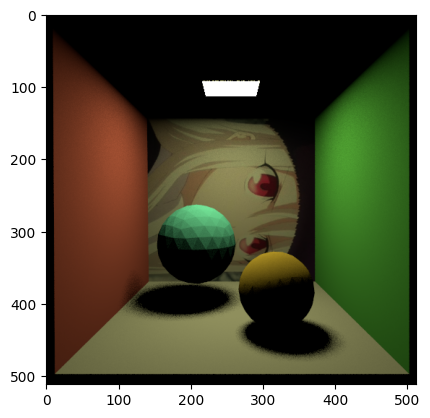

In [9]:
P = FloatD(0.) 
drjit.enable_grad(P) 

sc.param_map["Mesh[0]"].set_transform(Matrix4fD([[1.,0.,0.,P*100],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.],]))
sc.configure([0])

img = integrator.render(sc, 0)
org_img = img.numpy().reshape((sc.opts.width, sc.opts.height, 3))

org_img = to_srgb(np.asarray(org_img))
imgplot = plt.imshow(org_img)

# write_exr(str(output_path/"forward.exr"), org_img)

# drjit.set_grad(P, 1.0)
# drjit.forward_to(img)
# diff_img = drjit.grad(img)
# diff_img = diff_img.numpy().reshape((sc.opts.width, sc.opts.height, 3))
# write_exr(str(output_path/"backward_full.exr"), diff_img)

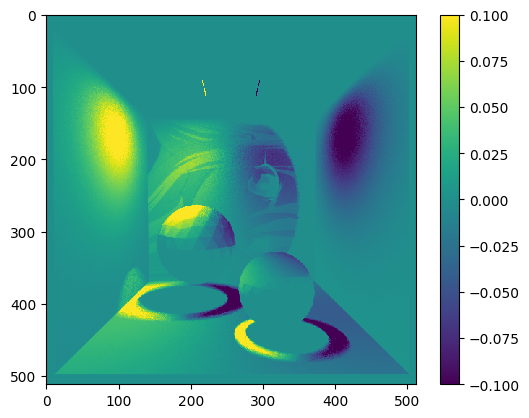

In [10]:
drjit.set_grad(P, 1.0)
drjit.forward_to(img)
diff_img = drjit.grad(img)
diff_img = diff_img.numpy().reshape((sc.opts.width, sc.opts.height, 3)).mean(axis=2)
plt.imshow(diff_img, interpolation='none', vmin=-.1, vmax=.1, cmap=plt.cm.viridis)
plt.colorbar()
